In [6]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
module_path = os.path.abspath(os.path.join('.'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import pandas as pd

pd.set_option('expand_frame_repr', True)
pd.set_option('max_colwidth', 500)
from matplotlib import pyplot as plt

In [7]:
from models.load_data import load_data
series = load_data(path='./data')
print('Number of observations: ', len(series))
print(series.info())

Number of observations:  314
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 5 columns):
id          314 non-null int64
series      314 non-null object
group_id    314 non-null int64
path_id     314 non-null int64
target      314 non-null int64
dtypes: int64(4), object(1)
memory usage: 12.3+ KB
None


The load_data function reads all the csv files in the data folder, format and join the groups/paths/RSS into one single pandas' Dataframe. All the columns are integers except the 'series' column which is a the RSS 2D floats matrix.  

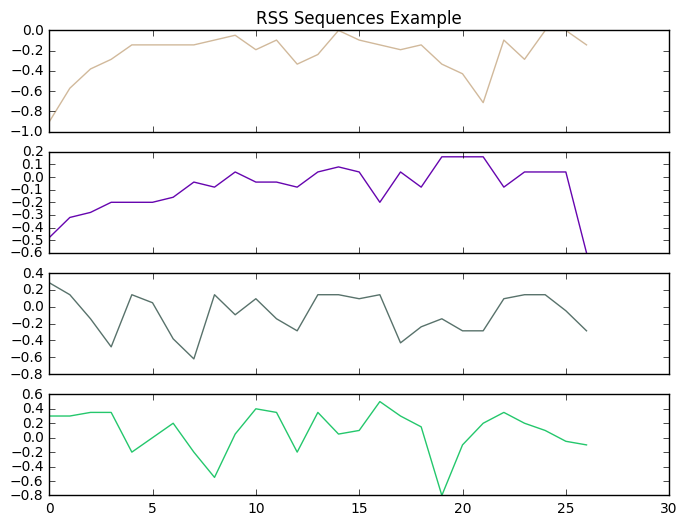

In [12]:
# Plotting Anchors Time Series
from models.utils import column
item = series.head(1)['series'][0]
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(8, 6))
axes[0].set_title('RSS Sequences Example')
for i in range(4):
    axes[i].plot(column(item, i), c=np.random.rand(3, 1))

plt.show()

The RSS signals have been rescaled to the interval [-1,1]. However, we can still seepeaks and some instability in the following time series plots which may require normalizing/smoothing the values.

Target data consists in a class label indicating whether the user's trajectory will lead to a change in the spatial context (i.e. a room change) or not. In particular, the target class +1 is associated to the location changing movements, while the target class -1 is associated to the location preserving movements. After grouping all of the data from sequence files and associating them with the corresponding Target value and the Path type, I proceeded to visualizing the data to get an idea on these multivariate times series and their relationship with the other attributes.

First, I used pie charts to see the distribution of each Path type in each dataset group (Pair of Rooms).

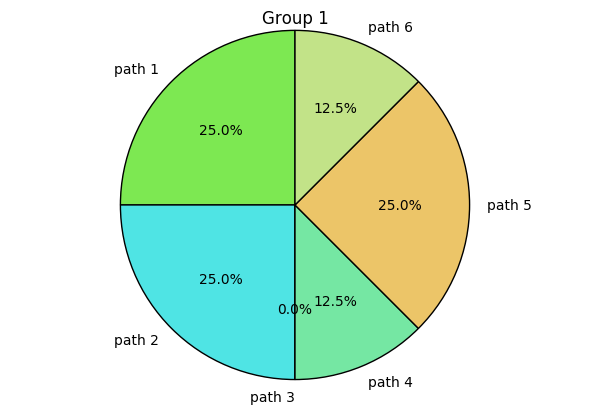

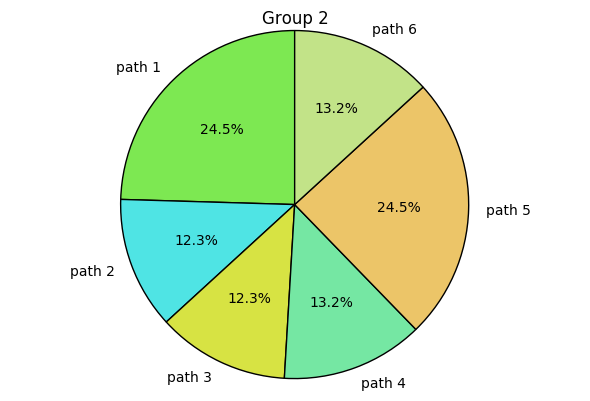

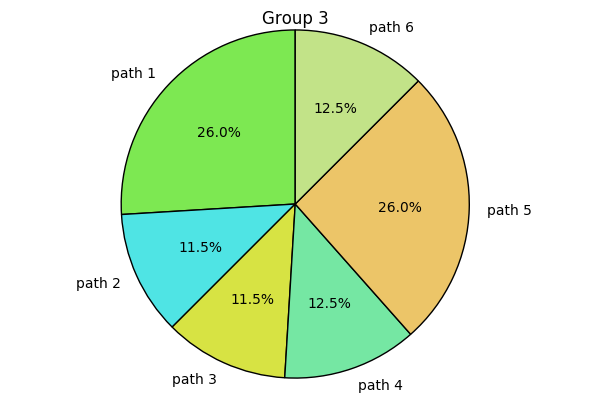

In [13]:
# Plot the composition of each group of measured paths
test = series.groupby(['group_id', 'path_id'])['path_id'].size().unstack(fill_value=0)
# Create a list of colors (from iWantHue)
colors = ["#7de852", "#4fe4e4", "#d7e343", "#75e7a3", "#ecc568", "#c2e388"]
paths = ['path {}'.format(i) for i in range(1,7)]
for i in range(1, 4):
    # Create a pie chart for each Group
    vals = test.loc[[i]].values.tolist()[0]
    plt.pie(vals, labels=paths, shadow=False, colors=colors, startangle=90, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title('Group {}'.format(i))
    # View the plot
    plt.tight_layout()
    plt.show()

We can see that Path 1 and Path 5 are the most dominant in the measurement compaign.We can confirm also that there is no Path 3 in Dataset Group 1 as mentioned above (due to physical constraints). The next plot shows the min, average, median and max length of sequences for each group.

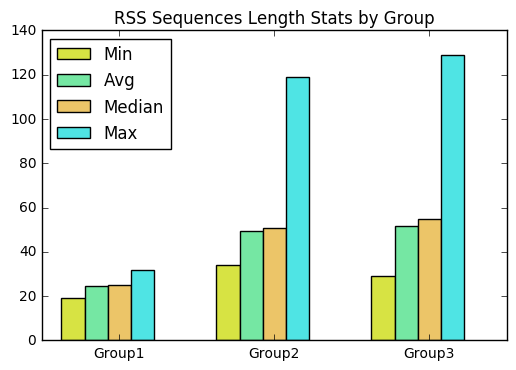

In [14]:
# Plot Min/Avg/Median/Max Sequence Length for each Group (Bar Chart)

series['length'] = series.apply(lambda x: len(x['series']), axis=1)
aggregations = {'length':
                    {'min': 'min',
                     'avg': 'mean',
                     'median': 'median',
                     'max': 'max'
                     }
                }

stats = series.groupby('group_id').agg(aggregations)

# I chose to plot each Bar one by one in order to have control over their order
# from lower to higher min<=avg<=median<=max
ax = plt.subplot(111)
w = 0.15
x = np.arange(1, 4)
ax.bar(x - 2 * w, stats.length['min'], width=w, color='#d7e343', align='center')
ax.bar(x - w, stats.length['avg'], width=w, color='#75e7a3', align='center')
ax.bar(x, stats.length['median'], width=w, color='#ecc568', align='center')
ax.bar(x + w, stats.length['max'], width=w, color='#4fe4e4', align='center')
plt.xticks(range(1, 4), ['Group1', 'Group2', 'Group3'])
plt.legend(["Min", "Avg", "Median", "Max"], loc=2)
plt.title('RSS Sequences Length Stats by Group')
plt.show()

We can notice that sequences or series in group 1 are way shorter that the two othergroups. This can be explained by the missing of Path of type 3. In general, we can see that the avg and median values are so close which convey a quasi normal distribution of the series lengths.

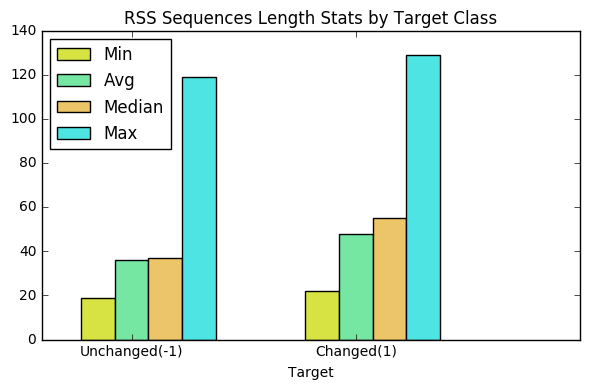

In [15]:
# I chose to plot each Bar one by one in order to have control over their order
# from lower to higher min<=avg<=median<=max
stats = series.groupby('target').agg(aggregations)

ax = plt.subplot(111)
w = 0.15
x = np.arange(1, 3)
ax.bar(x - w, stats.length['min'], width=w, color='#d7e343', align='center')
ax.bar(x, stats.length['avg'], width=w, color='#75e7a3', align='center')
ax.bar(x + w, stats.length['median'], width=w, color='#ecc568', align='center')
ax.bar(x + 2 * w, stats.length['max'], width=w, color='#4fe4e4', align='center')
plt.xticks(range(1, 4), ['Unchanged(-1)', 'Changed(1)'])
plt.xlabel("Target")
plt.legend(["Min", "Avg", "Median", "Max"], loc=2)
plt.title('RSS Sequences Length Stats by Target Class')
plt.tight_layout()
plt.show()

By calculating the same statistics but for each target class this time, we can see that sequences of movement inducing a change of rooms (Changed) are remarkably longerthat the other class. This is natural as the user have to walk a longer distance to cross the corridor and get to the other room. The next stacked bars chart indicates that the group has no effect pretty much on the target class.

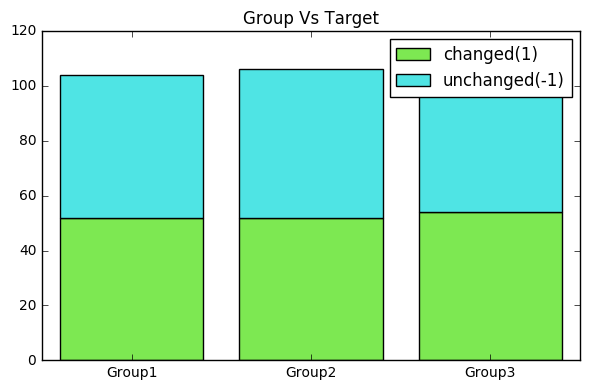

In [16]:
# Plot stacked bar charts to see group_ID Vs Target(Changed/Unchanged)
test = series.groupby(['group_id', 'target'])['target'].size().unstack(fill_value=0)
changed = test.iloc[:, 1].values
unchanged = test.iloc[:, 0].values
plt.bar(test.index.values, changed, color=colors[0], align='center')
plt.bar(test.index.values, unchanged, color=colors[1], align='center', bottom=changed)
plt.xticks(test.index.values, ['Group1', 'Group2', 'Group3'])
plt.legend(["changed(1)", "unchanged(-1)"])
plt.title('Group Vs Target')
# View the plot
plt.tight_layout()
plt.show()

This is not the case for the following stacked bars chart. We can see in fact that only Path 1 and 5 lead to a change of rooms and that was indicated in project descripting.

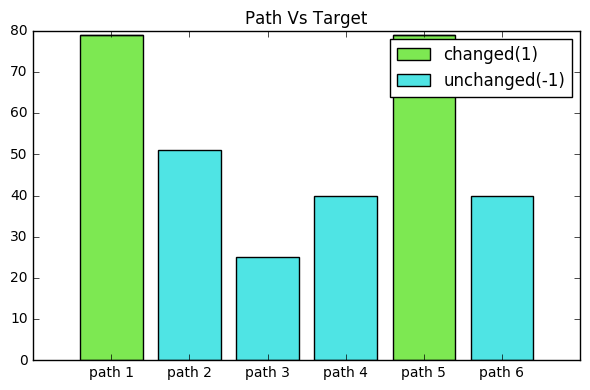

In [17]:
# Plot stacked bar charts to see path_ID Vs Target(Changed/Unchanged)
test = series.groupby(['path_id', 'target'])['target'].size().unstack(fill_value=0)
changed = test.iloc[:, 1].values
unchanged = test.iloc[:, 0].values
plt.bar(test.index.values, changed, color=colors[0], align='center')
plt.bar(test.index.values, unchanged, color=colors[1], align='center', bottom=changed)
plt.xticks(test.index.values, paths)
plt.legend(["changed(1)", "unchanged(-1)"])
plt.title('Path Vs Target')
# View the plot
plt.tight_layout()
plt.show()